# Sentiment Analysis: Sentiment classification using a pretrained fine tuned BERT model
- Refer to [BERT_Training](https://colab.research.google.com/drive/1FicAdDkFhe0rRobwbBSonmuNaSVFB3iZ?usp=sharing) notebook for trainig the model

# NOTES and REFRENCES:
- This notebook can only be run on the [Colab](https://colab.research.google.com/drive/1HABn0JGshF2TJGZmL061ABJgy8BvY1GE?usp=sharing). Running this notebook require usage of GPU runtime. Set runtime to GPU by going to menue bar "Runtime/change runtime" and select GPU.



Starting GPU, verify Runtime/runtime type==GPU

In [ ]:
!nvidia-smi

Wed Nov 18 00:09:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 12.0MB/s 
     |████████████████████████████████| 1.1MB 46.6MB/s 
     |████████████████████████████████| 890kB 56.9MB/s 
     |████████████████████████████████| 2.9MB 51.6MB/s 


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.4
torch 1.7.0+cu101
transformers 3.5.1


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from google.colab import files
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import re
import io
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

random_seed = 62
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## Import Dataset:

In [ ]:
# Un-commenet to Mount your google drive that contains the raw tweet data
from google.colab import drive
drive.mount('/content/gdrive')
# Or alternatively uncomment this line to upload the raw tweet dataset (156 files)
# uploaded = files.upload()

Mounted at /content/gdrive


In [ ]:
## Use this cell if tweet dataset is being read from drive ( Note:path variable should point to the location of dataset in drive)
path = '/content/gdrive/My Drive/DVA/output/dirlist.csv'
days = pd.read_csv(path,header=None)
days.tail()

,0
152,2020-08-04.csv
153,2020-08-05.csv
154,2020-08-06.csv
155,2020-08-07.csv
156,dirlist.txt


In [ ]:
## Use this cell if tweet dataset is uploaded
# days = pd.read_csv(io.BytesIO(uploaded['dirlist.csv']),header=None)
# days.head()

In [ ]:
# data_encoding = "ISO-8859-1"
# col_names = ["target", "ids", "date", "flag", "user", "text"]
# col_names = ["id", "text", "created_at", "lang", "geo","retweet_count",'favorite_count','place']

# import io
# raw_df = pd.read_csv(io.BytesIO(uploaded['2020-03-05.csv']))
# raw_df.head(10)

In [ ]:
%%time
dfs={}
for day in days[0]:
  if day !='dirlist.txt':
      # use below line if dataset is in Drive
      raw_df = pd.read_csv(f'/content/gdrive/My Drive/DVA/output/{day}')
      # use below line if dataset is uploaded
      # raw_df = pd.read_csv(io.BytesIO(uploaded[day]))
      
      # Dropping unnecessary columns
      raw_df = raw_df.drop(["geo","place"],axis=1)
      # Filtering english only tweets
      is_english = raw_df['lang']=='en'
      df = raw_df[is_english].copy()
      df = df.reset_index(drop=True)
      dfs[day]=df

CPU times: user 4.47 s, sys: 298 ms, total: 4.76 s
Wall time: 5.13 s


In [ ]:
# Number of days in dataset
len(dfs.keys())

156

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


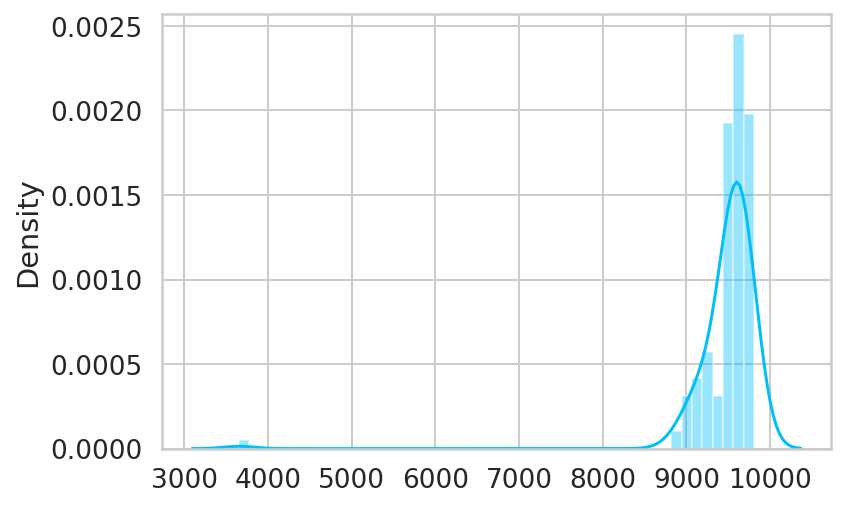

In [ ]:
# Distribution of number of english tweets for each day in the dataset
d=[df.shape[0] for df in dfs.values()]
sns.distplot(d)

In [ ]:
# Define the sentiment names
sentiment_names = ['negative', 'positive','neutral']

In [ ]:
pip install emoji --upgrade

     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=1b0c75347d8d833d637762d859f32ba55987d08e60585a6c27f865a00397cb85
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


## Data Preprosseing and Cleaning

In [ ]:

import emoji
def preprocess_text(tweet):
    tweet = emoji.demojize(tweet)
    # remove character that cause new line when converting to csv
    tweet = re.sub(r'\r\r|\r|\n\n|\n', '',tweet)
    # replace links with 'url'
    tweet = re.sub(r'((https?:\/\/)|(www\.))[A-Za-z0-9.\/]+', 'url',  tweet)
    tweet = re.sub(r'[A-Za-z0-9]+.com', 'url',tweet)
    # remove @users
    tweet = re.sub(r'[@][A-Za-z0-9]+', '',tweet)
    # remove non-ascii chars
    tweet = ''.join([w for w in tweet if ord(w)<128])
    # hastags: bert tokenizer handle such tokens
    tweet = tweet.strip()
    return tweet

In [ ]:
# sample tweet before text processing
dfs['2020-05-14.csv'].text[4404]

'The Best Coronavirus-Inspired Street Art From Around the World- The Discoverer\r\rhttps://t.co/KoidF6pJPv'

### Perform text processing on the dataset:

In [ ]:
%%time
for df in dfs.values():
  df.text = df.text.apply(lambda x: preprocess_text(x))

CPU times: user 22min 35s, sys: 302 ms, total: 22min 35s
Wall time: 22min 36s


In [ ]:
# sample tweet after text processing
dfs['2020-05-14.csv'].text[4404]

'The Best Coronavirus-Inspired Street Art From Around the World- The Discoverer\r\rurl'

## Text Encoding

###Import tokenizer from Bert cased based model

In [ ]:
BERT_model_type = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_model_type)

In [ ]:
# TEST the tokenizer on one tweet from dataset
test = preprocess_text(dfs['2020-03-05.csv'].text[6])
print(test)
max=32
encoding = tokenizer.encode_plus(
  test,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)
print(encoding['input_ids'])
encoding.keys()

:man_facepalming_light_skin_tone: (May I add an additional correction? No one in New York died from Corona)...but man, the fact that we are guided by hunches and thoughts rather than numbers and facts is really mind boggling :exploding_head: #COVID19 #coronavirus url
tensor([[  101,   131,  1299,   168,  1339, 12320,  5031,   168,  1609,   168,
          2241,   168,  3586,   131,   113,  1318,   146,  5194,  1126,  2509,
         22590,   136,  1302,  1141,  1107,  1203,  1365,  1452,  1121,  3291,
         15789,   102]])


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
%%time
# Find the distribution of text length to select a maximum length for text encoding
length_per_day=[]

for df in dfs.values():
  lenght_of_token = []
  for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512,truncation=True)
    lenght_of_token.append(len(tokens))
  length_per_day.append(lenght_of_token)

CPU times: user 13min 8s, sys: 129 ms, total: 13min 8s
Wall time: 13min 9s


In [ ]:
# Plot the the distribution of text lengths
for lenght_of_token in length_per_day:
  sns.distplot(lenght_of_token)
  plt.xlim([0, 146]);
  plt.xlabel('Token count');

In [ ]:
max_length = 140

In [ ]:
# Finction to encode texts into tensor of tokens
class EncodeTweetData(Dataset):
  def __init__ (self,tweets,tokenizer,max_length):
    self.tweets = tweets
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__ (self):
    return len(self.tweets)

  def __getitem__(self,item):
    tweet_txt = str(self.tweets[item])
    encoding = self.tokenizer.encode_plus(
          tweet_txt,
          max_length=self.max_length,
          add_special_tokens=True,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
    )
    return {
          'tweet_text': tweet_txt,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
    }


In [ ]:
# Function that performs text encoding and creat a dataloader
def make_data_loader(df, tokenizer, max_len, batch_size):
    ds = EncodeTweetData(
    tweets = df.text.to_numpy(),
    tokenizer = tokenizer,
    max_length = max_len
  )

    return DataLoader(ds,batch_size=batch_size,num_workers=4)

In [ ]:
# Batch size of 16 is selected based on the assumption in the trainig and recommendions of BERT model authors
batch_size = 16
daily_data_loaders = {}
# creat dictionary containig dataloaders for each day in our dataset
for day,df in dfs.items():
  daily_data_loaders[day] = make_data_loader(df, tokenizer, max_length, batch_size)


# Sentiment Analysis:


In [ ]:
# Class to perform sentiment classification
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(BERT_model_type)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

## Importing pre-trained BERT model:
Model can be uploaded from local directory or automatically downloaded from the link in the cell below

In [ ]:
# Use this cell if model needs to be uploaded. can upload different model state
# uploaded = files.upload()

In [ ]:
# This is the best state of the trained model with one epoch (best_model_state_e1.pth)
# to use any other model, upload the model in the above cell and comment the download code below
!gdown --id 1afvHvYRK2qvOMk-oVF6KDYrIO6hpUAik


Downloading...
From: https://drive.google.com/uc?id=1afvHvYRK2qvOMk-oVF6KDYrIO6hpUAik
To: /content/best_model_state_e1.pth
433MB [00:02, 168MB/s]


In [ ]:
# Loading the model and transfering to the GPU 
model = SentimentClassifier(len(sentiment_names))
model.load_state_dict(torch.load('best_model_state_e1.pth'))
model = model.to(device)

# Examples of sentiment analysis:

In [ ]:
# Sample Text: Replace with your own for testing
tweet_text ="With Corona now in the picture I would have a multi year BADD sentence."

In [ ]:
# Using the tokenizer to encode the tweet:
encoded_tweet= tokenizer.encode_plus(
  tweet_text,
  max_length=140,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
# Using model to get the sentiment probability and predition

input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
tweet_texts = []
predictions = []
prediction_probs = []
real_values = []
sentiment = []

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

with torch.no_grad():
  probs = F.softmax(output, dim=1)
  max_prob = torch.max(probs,dim=1)
  # assigning neutral tag to sentiments with less that 0.55 probability of 
  # being positive or negative
  sentiment_pred = torch.where(max_prob[0]<0.55,2,prediction)
  tweet_texts.extend(tweet_text)
  predictions.extend(prediction)
  prediction_probs.extend(probs)
  sentiment.extend(sentiment_pred)

  sentiment = torch.stack(sentiment).cpu()
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
pred_df = pd.DataFrame({
  'class_names': sentiment_names,
  'values': prediction_probs[0]
})

print(f'Tweet text: {tweet_text}')
print(f'Sentiment  : {sentiment_names[sentiment]}')

print(f'predictions  : {sentiment_names[predictions]}')
print(f'prediction_probs  : {pred_df}')

sns.barplot(x='values', y='class_names', data = pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Perfomming sentiment analysis:

In [ ]:
# Function to get prediction and probability distribution of each tweet using the pretrained model
def model_predict(model, data_loader):
  #  setting dropout and batch normalization layers to evaluation mode
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  sentiment = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probabilities = F.softmax(outputs, dim=1)

      max_prob = torch.max(probabilities,dim=1)
      # assigning neutral label to sentiments with less that 0.55 probability of 
      # being positive or negative
      sentiment_pred = torch.where(max_prob[0]<0.55,2,preds)


      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probabilities)
      sentiment.extend(sentiment_pred)


  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  sentiment = torch.stack(sentiment).cpu()

  return tweet_texts, predictions, prediction_probs ,sentiment

In [ ]:
%%time
# Perform sentiment analysis
pred_dict ={}
for day,data_loader in daily_data_loaders.items():
  y_tweet_texts, y_pred, y_pred_probs,sentiment_pred = model_predict(model,data_loader)
  pred_dict[day]=[y_tweet_texts, y_pred, y_pred_probs,sentiment_pred]



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

CPU times: user 2h 14min 55s, sys: 1h 44min 15s, total: 3h 59min 10s
Wall time: 4h 18s


# Results and Evaluation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CPU times: user 343 ms, sys: 102 ms, total: 446 ms
Wall time: 329 ms


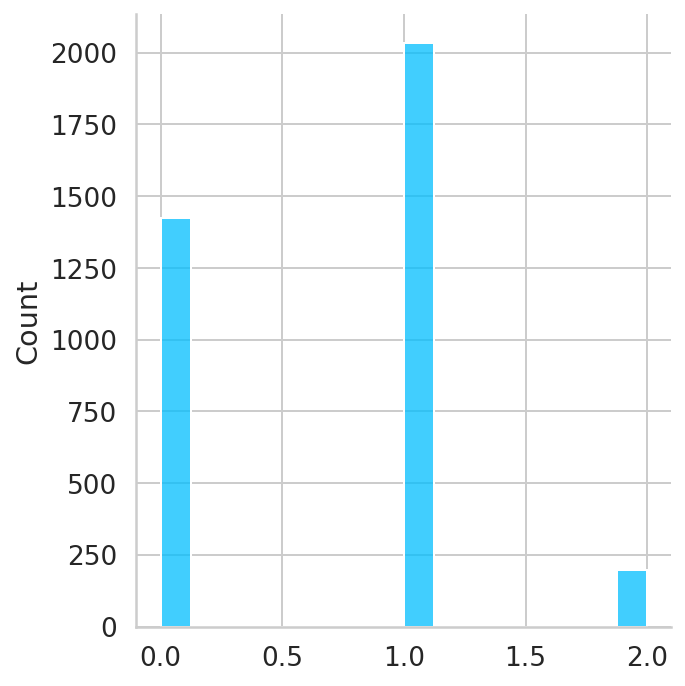

In [ ]:
%%time
# Test the output for March 5th:
y_pred = pred_dict['2020-03-05.csv'][3]
pred=y_pred.numpy()
cls, freq = np.unique(pred, return_counts=True)
count_dict = dict(zip(cls, freq))
sns.displot(pred)
sent_per_day={'date':[],'negative':[],'neutral':[],'positive':[]}
 

for day,pred in pred_dict.items():
  cls, freq = np.unique(pred[3], return_counts=True)
  count_dict = dict(zip(cls, freq))
  sent_per_day['date'].append(day)
  sent_per_day['negative'].append(count_dict[0])
  sent_per_day['positive'].append(count_dict[1])
  sent_per_day['neutral'].append(count_dict[2])

df_result=pd.DataFrame.from_dict(sent_per_day)

df_result.to_csv('Overal_result.csv')

# Downloading the overl result containg the frequency of each sentiment for each day in the datset
files.download('Overal_result.csv')

In [ ]:
# Creat a temproray file in the cloud to save the result of each day
!mkdir 'result'

In [ ]:
# Compiling dictionary containig the result for all tweets and for each day separately
def get_scalar(tensor_array):
  return tensor_array.item()


vec_get_scalar = np.vectorize(get_scalar)
result_list=[]
for day,pred in pred_dict.items(): 
  df=pd.DataFrame(pred,index=['text','prediction','probability','sentiment'])
  df = df.transpose() 
  df['prob_negative']= df[['probability']].applymap(lambda x:x.numpy()[0])
  df['prob_positive']= df[['probability']].applymap(lambda x:x.numpy()[1])
  df['prob_neutral']= df[['probability']].applymap(lambda x:x.numpy()[2])
  df=df.drop('probability',axis=1)
  df[['prediction','sentiment']] = vec_get_scalar(df[['prediction','sentiment']])
  df = df[['text','prob_negative','prob_positive','prob_neutral','prediction','sentiment']]

  
  df.to_csv(f'result/Result_{day}')

In [ ]:
# Creating a zip file containig all the results in the result folder and saving in the file.zip file
!zip -r /content/file.zip /content/result

  adding: content/result/ (stored 0%)
  adding: content/result/Result_2020-07-02.csv (deflated 63%)
  adding: content/result/Result_2020-07-07.csv (deflated 65%)
  adding: content/result/Result_2020-05-19.csv (deflated 61%)
  adding: content/result/Result_2020-06-11.csv (deflated 61%)
  adding: content/result/Result_2020-04-16.csv (deflated 58%)
  adding: content/result/Result_2020-05-02.csv (deflated 61%)
  adding: content/result/Result_2020-06-09.csv (deflated 63%)
  adding: content/result/Result_2020-06-07.csv (deflated 69%)
  adding: content/result/Result_2020-05-27.csv (deflated 60%)
  adding: content/result/Result_2020-07-21.csv (deflated 60%)
  adding: content/result/Result_2020-06-29.csv (deflated 66%)
  adding: content/result/Result_2020-06-14.csv (deflated 76%)
  adding: content/result/Result_2020-04-12.csv (deflated 60%)
  adding: content/result/Result_2020-03-30.csv (deflated 65%)
  adding: content/result/Result_2020-06-05.csv (deflated 64%)
  adding: content/result/Result_

In [ ]:
# Downloading the final daily results
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot: Sentiment frequency VS Date

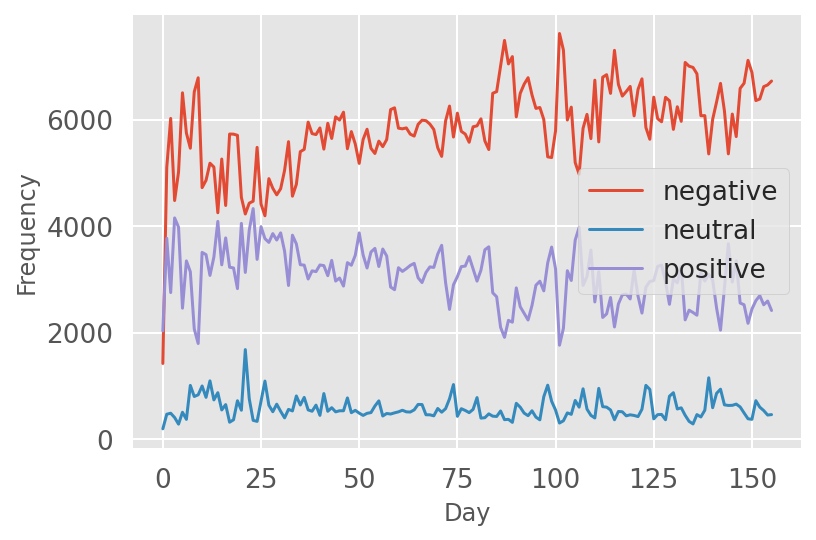

In [ ]:
plt.style.use("ggplot")
df_result.plot(xlabel='Day',ylabel='Frequency')

In [ ]:
sent_per_day={'date':[],'negative':[],'neutral':[],'positive':[]}
for day,pred in pred_dict.items():
  cls, freq = np.unique(pred[3], return_counts=True)
  count_dict = dict(zip(cls, freq))
  date=day[:-4]
  # print(date)
  sent_per_day['date'].append(date)
  sent_per_day['negative'].append(count_dict[0])
  sent_per_day['positive'].append(count_dict[1])
  sent_per_day['neutral'].append(count_dict[2])

df_result_2=pd.DataFrame.from_dict(sent_per_day)
df_result_2.head()

,date,negative,neutral,positive
0,2020-03-05,1424,198,2034
1,2020-03-06,5104,472,3774
2,2020-03-07,6023,491,2755
3,2020-03-08,4482,410,4156
4,2020-03-09,5018,286,3982
